# Evaluate Dst forecasts

> The baseline is the benchmark by Licata et. al.

In [30]:
# Imports
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices() # fix to make the script work in the MIT supercloud
from swdf.benchmark import *
from tsai.basics import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
wandb_api = wandb.Api()

In [31]:
# Constants
# ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/dst_eval_tmp"

In [32]:
# Config
config = yaml2dict('config/geodstap.yaml')
config = config.eval
config

```json
{ 'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'round_preds': True,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'}
```

In [33]:
# TODO
# learn.path = Path(path)
# learn.model_dir = Path()
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)

learn_trend = load_learner_all(learner_path, learner_fname='learner_dstap_trend' ,model_fname = 'model_dstap_trend', 
                         verbose=True, 
                         device=default_device())

learn_seasonal = load_learner_all(learner_path, learner_fname='learner_dstap_seasonal' ,model_fname = 'model_dstap_seasonal', 
                         verbose=True, 
                         device=default_device())

learn_residual = load_learner_all(learner_path, learner_fname='learner_dstap_residual' ,model_fname = 'model_dstap_residual', 
                         verbose=True, 
                         device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_trend.pth'
learner_fname = 'learner_dstap_trend.pkl'
Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_seasonal.pth'
learner_fname = 'learner_dstap_seasonal.pkl'
Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_residual.pth'
learner_fname = 'learner_dstap_residual.pkl'


In [34]:
y_test_preds_trend, y_test_trend, _ = learn_trend.get_preds(ds_idx = 2, with_targs=True, with_loss=True)
y_test_preds_seasonal, y_test_seasonal, _ =  learn_seasonal.get_preds(ds_idx = 2, with_targs=True, with_loss=True)
y_test_preds_residual, y_test_residual, _ =  learn_residual.get_preds(ds_idx = 2, with_targs=True, with_loss=True)

y_test_preds = y_test_preds_trend + y_test_preds_seasonal + y_test_preds_residual
y_test = y_test_trend + y_test_seasonal + y_test_residual

y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (15296, 2, 48)


In [35]:
device = 'cuda:0'

y_test_preds = totensor(y_test_preds).to(device)
y_test = totensor(y_test).to(device)

In [36]:
horizon = y_test.shape[-1]
horizon_days = int(np.ceil(horizon / 8))
data_columns_fcst = ['DST']
horizon, horizon_days

(48, 6)

The threshold classify the forecasts of Dst are based on the values of the Dst itself
and the solar activity level, as defined by the F10.7 (according to Licata et al.).
Therefore, below is the table of all possible combined conditions to evaluate Dst.

| Dst Level | Solar Level | Dst Value         | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| G0        | Low         | Dst ≥ -30         | F 10.7 ≤ 75       |
| G0        | Moderate    | Dst ≥ -30         | 75 < F 10.7 ≤ 150 |
| G0        | Elevated    | Dst ≥ -30         | 150 < F 10.7 ≤ 190|
| G0        | High        | Dst ≥ -30         | F 10.7 > 190      |
| G1        | Low         | -30 > Dst ≥ -50   | F 10.7 ≤ 75       |
| G1        | Moderate    | -30 > Dst ≥ -50   | 75 < F 10.7 ≤ 150 |
| G1        | Elevated    | -30 > Dst ≥ -50   | 150 < F 10.7 ≤ 190|
| G1        | High        | -30 > Dst ≥ -50   | F 10.7 > 190      |
| G2        | Low         | -50 > Dst ≥ -90   | F 10.7 ≤ 75       |
| G2        | Moderate    | -50 > Dst ≥ -90   | 75 < F 10.7 ≤ 150 |
| G2        | Elevated    | -50 > Dst ≥ -90   | 150 < F 10.7 ≤ 190|
| G2        | High        | -50 > Dst ≥ -90   | F 10.7 > 190      |
| G3        | Low         | -90 > Dst ≥ -130  | F 10.7 ≤ 75       |
| G3        | Moderate    | -90 > Dst ≥ -130  | 75 < F 10.7 ≤ 150 |
| G3        | Elevated    | -90 > Dst ≥ -130  | 150 < F 10.7 ≤ 190|
| G3        | High        | -90 > Dst ≥ -130  | F 10.7 > 190      |
| G4        | Low         | -130 > Dst ≥ -350 | F 10.7 ≤ 75       |
| G4        | Moderate    | -130 > Dst ≥ -350 | 75 < F 10.7 ≤ 150 |
| G4        | Elevated    | -130 > Dst ≥ -350 | 150 < F 10.7 ≤ 190|
| G4        | High        | -130 > Dst ≥ -350 | F 10.7 > 190      |
| G5        | Low         | Dst ≤ -350        | F 10.7 ≤ 75       |
| G5        | Moderate    | Dst ≤ -350        | 75 < F 10.7 ≤ 150 |
| G5        | Elevated    | Dst ≤ -350        | 150 < F 10.7 ≤ 190|
| G5        | High        | Dst ≤ -350        | F 10.7 > 190      |


In order to create all those combined conditions, let's merge the data from Dst
and F10.7. Since this data is provided with different frequencies (1 day for F10.7 
and 1 hour for Dst, we will fill the missing timestamps of F10.7 with forward-filling)


In [37]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")
df_dstap = load_object("./preprocessed_data/dataframes/geodstap.pkl")

In [38]:
df_F10['Datetime'] = df_F10['Datetime'] - pd.Timedelta(hours=12)

# Merge the DST and F10.7 dataframes on the datetime column, and keep only the columns we need
df_combined = pd.merge(df_dstap, df_F10, on='Datetime', how='left')
df_combined = df_combined[['Datetime', 'DST', 'AP', 'F10']]

# The F10 is given only at 12:00 (00:00 now that we shifted), so we'll forward 
# fill the rest of the values
df_combined['F10'] = df_combined['F10'].ffill()
df_combined.head()
df_combined

,Datetime,DST,AP,F10
0,1957-01-01 00:00:00,12.000000,2,255.2
1,1957-01-01 03:00:00,9.300000,3,255.2
2,1957-01-01 06:00:00,5.000000,3,255.2
3,1957-01-01 09:00:00,-5.000000,22,255.2
4,1957-01-01 12:00:00,0.000000,15,255.2
...,...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5,71.3
197519,2024-08-06 21:00:00,-18.700001,6,71.3
197520,2024-08-07 00:00:00,-17.299999,4,71.3
197521,2024-08-07 03:00:00,-16.000000,6,71.3


In [39]:
#|export

all_possible_dst_conditions = ['G0_Low', 'G0_Moderate', 'G0_Elevated', 'G0_High',
                                 'G1_Low', 'G1_Moderate', 'G1_Elevated', 'G1_High',
                                 'G2_Low', 'G2_Moderate', 'G2_Elevated', 'G2_High',
                                 'G3_Low', 'G3_Moderate', 'G3_Elevated', 'G3_High',
                                 'G4_Low', 'G4_Moderate', 'G4_Elevated', 'G4_High',
                                 'G5_Low', 'G5_Moderate', 'G5_Elevated', 'G5_High',]

def get_dst_condition(dst, f107):
    """
        Function that returns the Dst condition based on the Dst and F10.7 values.
        Input:
        dst: Dst value (float)
        f107: F10.7 value (float)
        Output:
        dst_condition: Dst condition (string)
    """
    if dst >= -30:
        if f107 <= 75:
            dst_condition = 'G0_Low'
        elif f107 <= 150:
            dst_condition = 'G0_Moderate'
        elif f107 <= 190:
            dst_condition = 'G0_Elevated'
        else:
            dst_condition = 'G0_High'
    elif dst >= -50:
        if f107 <= 75:
            dst_condition = 'G1_Low'
        elif f107 <= 150:
            dst_condition = 'G1_Moderate'
        elif f107 <= 190:
            dst_condition = 'G1_Elevated'
        else:
            dst_condition = 'G1_High'
    elif dst >= -90:
        if f107 <= 75:
            dst_condition = 'G2_Low'
        elif f107 <= 150:
            dst_condition = 'G2_Moderate'
        elif f107 <= 190:
            dst_condition = 'G2_Elevated'
        else:
            dst_condition = 'G2_High'
    elif dst >= -130:
        if f107 <= 75:
            dst_condition = 'G3_Low'
        elif f107 <= 150:
            dst_condition = 'G3_Moderate'
        elif f107 <= 190:
            dst_condition = 'G3_Elevated'
        else:
            dst_condition = 'G3_High'
    elif dst >= -350:
        if f107 <= 75:
            dst_condition = 'G4_Low'
        elif f107 <= 150:
            dst_condition = 'G4_Moderate'
        elif f107 <= 190:
            dst_condition = 'G4_Elevated'
        else:
            dst_condition = 'G4_High'
    else:
        if f107 <= 75:
            dst_condition = 'G5_Low'
        elif f107 <= 150:
            dst_condition = 'G5_Moderate'
        elif f107 <= 190:
            dst_condition = 'G5_Elevated'
        else:
            dst_condition = 'G5_High'
    return dst_condition

# Vectorize the get_dst_condition function
get_dst_condition_vec = np.vectorize(get_dst_condition)

In [40]:
all_possible_ap_conditions = ['LowGeo_Low', 'LowGeo_Moderate', 'LowGeo_Elevated', 'LowGeo_High',
                                 'ModGeo_Low', 'ModGeo_Moderate', 'ModGeo_Elevated', 'ModGeo_High',
                                 'ActGeo_Low', 'ActGeo_Moderate', 'ActGeo_Elevated', 'ActGeo_High',]

def get_ap_condition(ap, f107):
    """
        Function that returns the Ap condition based on the Ap and F10.7 values.
        Input:
        Ap: Ap value (float)
        f107: F10.7 value (float)
        Output:
        ap_condition: Ap condition (string)
    """
    if ap <= 10:
        if f107 <= 75:
            ap_condition = 'LowGeo_Low'
        elif f107 <= 150:
            ap_condition = 'LowGeo_Moderate'
        elif f107 <= 190:
            ap_condition = 'LowGeo_Elevated'
        else:
            ap_condition = 'LowGeo_High'
    elif ap <= 50:
        if f107 <= 75:
            ap_condition = 'ModGeo_Low'
        elif f107 <= 150:
            ap_condition = 'ModGeo_Moderate'
        elif f107 <= 190:
            ap_condition = 'ModGeo_Elevated'
        else:
            ap_condition = 'ModGeo_High'
    else:
        if f107 <= 75:
            ap_condition = 'ActGeo_Low'
        elif f107 <= 150:
            ap_condition = 'ActGeo_Moderate'
        elif f107 <= 190:
            ap_condition = 'ActGeo_Elevated'
        else:
            ap_condition = 'ActGeo_High'
    return ap_condition

# Vectorize the get_ap_condition function
get_ap_condition_vec = np.vectorize(get_ap_condition)

In [41]:
# Add the condition column to the dataframe
df_combined["DST Condition"] = get_dst_condition_vec(df_combined["DST"], 
                                                 df_combined["F10"])
df_combined["AP Condition"] = get_ap_condition_vec(df_combined["AP"], 
                                                 df_combined["F10"])
df_combined

,Datetime,DST,AP,F10,DST Condition,AP Condition
0,1957-01-01 00:00:00,12.000000,2,255.2,G0_High,LowGeo_High
1,1957-01-01 03:00:00,9.300000,3,255.2,G0_High,LowGeo_High
2,1957-01-01 06:00:00,5.000000,3,255.2,G0_High,LowGeo_High
3,1957-01-01 09:00:00,-5.000000,22,255.2,G0_High,ModGeo_High
4,1957-01-01 12:00:00,0.000000,15,255.2,G0_High,ModGeo_High
...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5,71.3,G0_Low,LowGeo_Low
197519,2024-08-06 21:00:00,-18.700001,6,71.3,G0_Low,LowGeo_Low
197520,2024-08-07 00:00:00,-17.299999,4,71.3,G0_Low,LowGeo_Low
197521,2024-08-07 03:00:00,-16.000000,6,71.3,G0_Low,LowGeo_Low


In [42]:
X_combined, y_combined = prepare_forecasting_data(df_combined, 
                                                  fcst_history=learn_trend.dls.len, 
                                                  fcst_horizon=learn_trend.dls.d[-1],
                                                  x_vars=['DST', 'AP', 'F10', 'Datetime'], 
                                                  y_vars=['DST', 'AP', 'F10', 'Datetime'])
X_combined.shape, y_combined.shape

((197332, 4, 144), (197332, 4, 48))

In [43]:
#| export

def split_data_by_dstap_f107(data):
    """
        function that splits the Dst data into all the possible Dst x F10.7 combinations
        according to the thresholds defined above. # The decision is made based on 
        the timestemp of each sample
        The function returns a dictionary with the Dst x F10.7 combinations as keys
        and the corresponding samples that match the condition as values.
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        data_split: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding Dst data as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result_dst = get_dst_condition_vec(first_timestep_data[:, 0], first_timestep_data[:, 2])
    result_ap = get_ap_condition_vec(first_timestep_data[:, 1], first_timestep_data[:, 2])


    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    data_split = {}
    for dst_condition in all_possible_dst_conditions:
        data_split[dst_condition] = data[result_dst == dst_condition]
    for ap_condition in all_possible_ap_conditions:
        data_split[ap_condition] = data[result_ap == ap_condition]
    
    return data_split

def get_idxs_per_dstap_condition(data):
    """
        Function that returns the indices of the samples that match each 
        Dst x F10.7 condition
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        idxs: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding indices as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result_dst = get_dst_condition_vec(first_timestep_data[:, 0], first_timestep_data[:, 2])
    result_ap = get_ap_condition_vec(first_timestep_data[:, 1], first_timestep_data[:, 2])


    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    idxs = {}
    for dst_condition in all_possible_dst_conditions:
        idxs[dst_condition] = np.where(result_dst == dst_condition)[0]

    for ap_condition in all_possible_ap_conditions:
        idxs[ap_condition] = np.where(result_ap == ap_condition)[0]
    return idxs

In [44]:
y_combined_train = y_combined[learn_trend.dls[0].splits]
y_combined_valid = y_combined[learn_trend.dls[1].splits]
y_combined_test = y_combined[learn_trend.dls[2].splits]

y_combined_train.shape, y_combined_valid.shape, y_combined_test.shape

((162710, 4, 48), (19088, 4, 48), (15296, 4, 48))

In [45]:
# Splitn y_combined and y_combined_test by Dst x F10.7 combinations
y_combined_train_split = split_data_by_dstap_f107(y_combined_train)
y_combined_valid_split = split_data_by_dstap_f107(y_combined_valid)
y_combined_test_split = split_data_by_dstap_f107(y_combined_test)

# Compare the distributions of the Dst x F10.7 combinations in the training, validation and test sets
print('{:<20} {:<20} {:<20} {}'.format("Condition", "Train", "Valid", "Test"))
for key in all_possible_dst_conditions + all_possible_ap_conditions:
    print('{:<20} {:<20} {:<20} {}'.format(
        key, 
        str(ifnone(y_combined_train_split.get(key),np.array([])).shape),
        str(ifnone(y_combined_valid_split.get(key), np.array([])).shape), 
        str(ifnone(y_combined_test_split.get(key), np.array([])).shape)))

Condition            Train                Valid                Test
G0_Low               (27569, 4, 48)       (17747, 4, 48)       (1734, 4, 48)
G0_Moderate          (70850, 4, 48)       (61, 4, 48)          (10017, 4, 48)
G0_Elevated          (18812, 4, 48)       (0, 4, 48)           (1376, 4, 48)
G0_High              (15975, 4, 48)       (0, 4, 48)           (151, 4, 48)
G1_Low               (1934, 4, 48)        (934, 4, 48)         (120, 4, 48)
G1_Moderate          (9396, 4, 48)        (3, 4, 48)           (1175, 4, 48)
G1_Elevated          (3733, 4, 48)        (0, 4, 48)           (162, 4, 48)
G1_High              (4008, 4, 48)        (0, 4, 48)           (31, 4, 48)
G2_Low               (402, 4, 48)         (285, 4, 48)         (15, 4, 48)
G2_Moderate          (3566, 4, 48)        (0, 4, 48)           (375, 4, 48)
G2_Elevated          (1820, 4, 48)        (0, 4, 48)           (59, 4, 48)
G2_High              (2399, 4, 48)        (0, 4, 48)           (1, 4, 48)
G3_Low              

In [46]:
# Get the idxs (with respect to the test set) of the samples that match 
# each Dst x F10.7 condition
y_test_split_idxs = get_idxs_per_dstap_condition(y_combined_test)
for key, value in y_test_split_idxs.items():
    print(key, value.shape)

G0_Low (1734,)
G0_Moderate (10017,)
G0_Elevated (1376,)
G0_High (151,)
G1_Low (120,)
G1_Moderate (1175,)
G1_Elevated (162,)
G1_High (31,)
G2_Low (15,)
G2_Moderate (375,)
G2_Elevated (59,)
G2_High (1,)
G3_Low (0,)
G3_Moderate (63,)
G3_Elevated (3,)
G3_High (1,)
G4_Low (0,)
G4_Moderate (13,)
G4_Elevated (0,)
G4_High (0,)
G5_Low (0,)
G5_Moderate (0,)
G5_Elevated (0,)
G5_High (0,)
LowGeo_Low (1290,)
LowGeo_Moderate (8565,)
LowGeo_Elevated (1195,)
LowGeo_High (137,)
ModGeo_Low (566,)
ModGeo_Moderate (2873,)
ModGeo_Elevated (385,)
ModGeo_High (44,)
ActGeo_Low (13,)
ActGeo_Moderate (205,)
ActGeo_Elevated (20,)
ActGeo_High (3,)


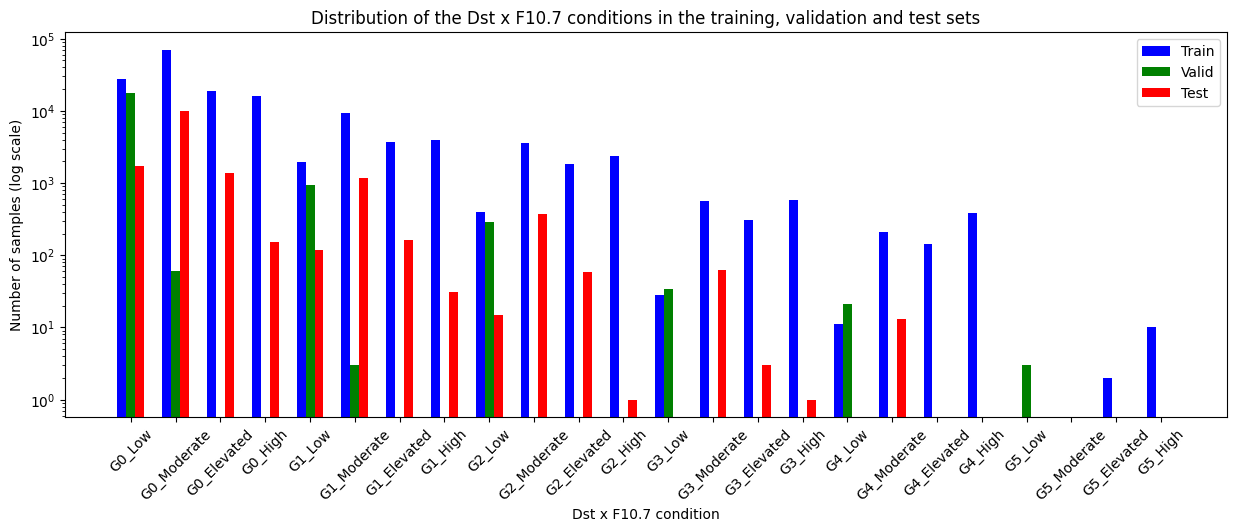

In [47]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the Dst x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_possible_dst_conditions))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_possible_dst_conditions)),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_possible_dst_conditions))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_possible_dst_conditions)))
ax.set_xticklabels(all_possible_dst_conditions, rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('Dst x F10.7 condition')
ax.set_title('Distribution of the Dst x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

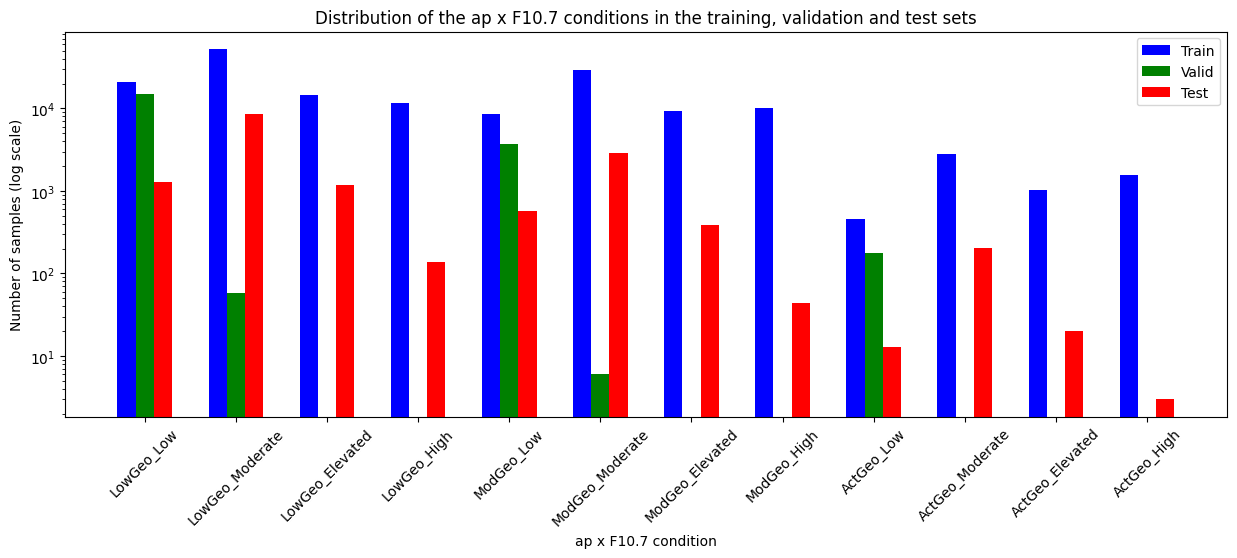

In [48]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the ap x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_possible_ap_conditions))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_possible_ap_conditions],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_possible_ap_conditions)),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_possible_ap_conditions], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_possible_ap_conditions))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_possible_ap_conditions],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_possible_ap_conditions)))
ax.set_xticklabels(all_possible_ap_conditions, rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('ap x F10.7 condition')
ax.set_title('Distribution of the ap x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

In [49]:
# Split y_test and y_test_preds with the idxs from y_test_split_idxs
y_test_split = {}
y_test_preds_split = {}
for key, value in y_test_split_idxs.items():
    y_test_split[key] = y_test[value]
    y_test_preds_split[key] = y_test_preds[value]

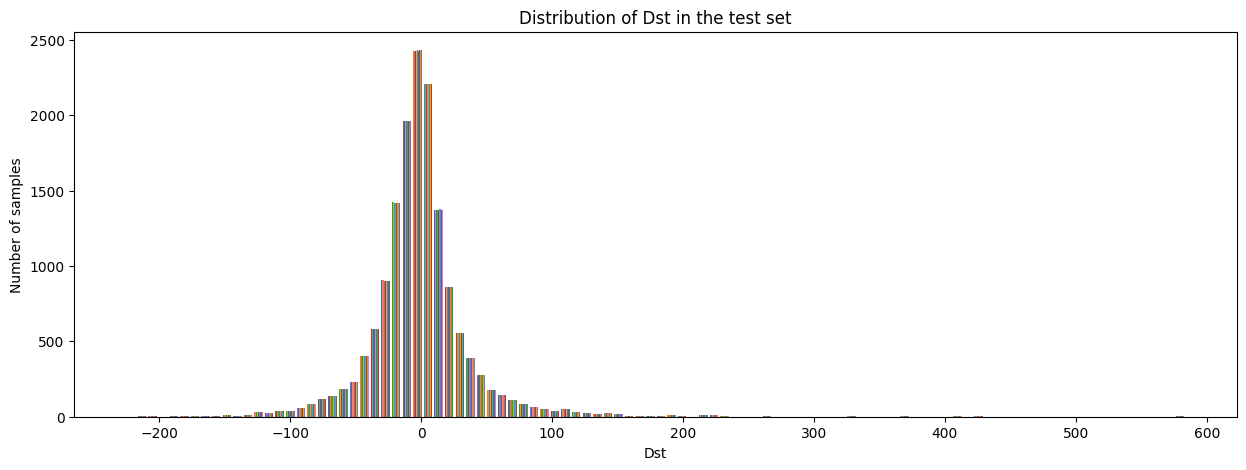

In [50]:
# Plot the distribution of y_test
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(y_test[:, 0, :].cpu(), bins=100)
ax.set_xlabel('Dst')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of Dst in the test set')
plt.show()


In [51]:
# Create a dataframe with the mean forecast error for the Dst in each 
# Dst x F10.7 condition and each horizon. The horizon is given in days in the
# dataframe, but the actual horizon in the data is given in hours
data = []
for condition in all_possible_dst_conditions + all_possible_ap_conditions:
    if y_test_split.get(condition) is not None and \
    y_test_split.get(condition).shape[0] > 0:
        # Apply forecast_error to every horizon (1..horizon)
        fe_sfu = np.array([forecast_error(y_test_split[condition][:, 0, :].cpu(),
                                        y_test_preds_split[condition][:, 0, :].cpu(), 
                                        h) for h in range(1, horizon+1)]).astype(np.float64)
        fe_percent = np.array([percent_forecast_error(y_test_split[condition][:, 0, :].cpu(),
                                                    y_test_preds_split[condition][:, 0, :].cpu(), 
                                                    h) for h in range(1, horizon+1)]).astype(np.float64)
        # Aggregate the forecast every 8 hours (get mean and std)
        # TODO: This code breaks if the max horizon is not a multiple of 8
        fe_nT_mean = np.array([np.mean(fe_sfu[i:i+8]) for i in range(0, horizon, 8)])
        fe_nT_std = np.array([np.std(fe_sfu[i:i+8]) for i in range(0, horizon, 8)])
        #fe_percent_mean = np.array([np.mean(fe_percent[i:i+8]) for i in range(0, horizon, 8)])
        #fe_percent_std = np.array([np.std(fe_percent[i:i+8]) for i in range(0, horizon, 8)])
        # additional columns
        h_days = np.arange(1, (horizon // 8) + 1)
        n_samples = y_test_split[condition].shape[0]
        # Append the data to the list
        for h_day, mean, std in zip(h_days, fe_nT_mean, fe_nT_std):
            data.append((condition, h_day, mean, std, n_samples))
# Create the dataframe        
df_results = pd.DataFrame(data, columns=['condition', 'horizon_days', 
                                         'fe_nT_mean', 'fe_nT_std', 'n_samples'])
df_results.head(10)

,condition,horizon_days,fe_nT_mean,fe_nT_std,n_samples
0,G0_Low,1,9.289947,27.169429,1734
1,G0_Low,2,8.634162,34.888861,1734
2,G0_Low,3,8.738053,36.816684,1734
3,G0_Low,4,9.504541,37.517421,1734
4,G0_Low,5,9.617426,37.747844,1734
5,G0_Low,6,8.101853,38.490449,1734
6,G0_Moderate,1,9.340287,37.513390,10017
7,G0_Moderate,2,7.389820,44.694704,10017
8,G0_Moderate,3,7.105726,45.942982,10017
9,G0_Moderate,4,8.357781,45.313679,10017


In [52]:
# compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_dst_paper = pd.read_csv('../data/benchmark_results_dst.csv', comment = '#')
df_results_ap_paper = pd.read_csv('../data/benchmark_results_ap.csv', comment = '#')

df_results_paper = pd.concat([df_results_dst_paper, df_results_ap_paper])

df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']
# Rename mu with fe_nT_mean and sigma with fe_nT_std in the statistics column
df_results_paper['statistic'] = df_results_paper['statistic'].replace({
    'mu': 'fe_nT_mean', 
    'sigma': 'fe_nT_std'
    })
df_results_paper.tail()

,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
13,LowGeo_Elevated,fe_nT_std,7.2675,7.6940,7.9520,9.0765,8.6062,6.2746
15,ModGeo_Elevated,fe_nT_mean,2.9701,2.7038,1.2755,-7.7028,-7.6295,-8.0547
16,ModGeo_Elevated,fe_nT_std,10.9766,12.0786,11.9995,10.0915,10.2440,10.7734
18,ModGeo_High,fe_nT_mean,8.1667,5.2540,0.5079,-7.9921,-9.0397,-10.3968
19,ModGeo_High,fe_nT_std,15.2611,12.7671,8.9307,7.3996,8.1156,10.3549


In [53]:
# Convert the dfs with results into long format
df_results_long = pd.melt(df_results, id_vars=['condition', 'horizon_days'],
                            value_vars=['fe_nT_mean', 'fe_nT_std'],
                            var_name='statistic', value_name='value')
df_results_long.head()

,condition,horizon_days,statistic,value
0,G0_Low,1,fe_nT_mean,9.289947
1,G0_Low,2,fe_nT_mean,8.634162
2,G0_Low,3,fe_nT_mean,8.738053
3,G0_Low,4,fe_nT_mean,9.504541
4,G0_Low,5,fe_nT_mean,9.617426


In [54]:
df_results_paper_long = df_results_paper.melt(id_vars=['condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon_days+1)],
                                            var_name='horizon_days', value_name='value')
df_results_paper_long['horizon_days'] = df_results_paper_long['horizon_days'].str.replace(
    ' Days', '').astype(int)
df_results_paper_long.head()

,condition,statistic,horizon_days,value
0,G0_Low,fe_nT_mean,1,1.1077
1,G0_Low,fe_nT_std,1,14.6264
2,G0_Moderate,fe_nT_mean,1,8.8130
3,G0_Moderate,fe_nT_std,1,18.2244
4,G0_Elevated,fe_nT_mean,1,9.6871


In [55]:
# Join the two dataframes (paper and ours) into one, merging on the condition and
# statistic. Right merge (paper)
df_results_merged = pd.merge(df_results_long, df_results_paper_long,
                            on=['condition', 'statistic', 'horizon_days'], how='right',
                            suffixes=('_ours', '_benchmark'))

df_results_merged.tail()

,condition,horizon_days,statistic,value_ours,value_benchmark
187,LowGeo_Elevated,6,fe_nT_std,38.569424,6.2746
188,ModGeo_Elevated,6,fe_nT_mean,17.305069,-8.0547
189,ModGeo_Elevated,6,fe_nT_std,40.065330,10.7734
190,ModGeo_High,6,fe_nT_mean,18.981805,-10.3968
191,ModGeo_High,6,fe_nT_std,49.935513,10.3549


In [56]:
data_dst = df_results_merged[df_results_merged.condition.isin(all_possible_dst_conditions)].copy()
data_dst[['Dst level', 'Solar activity level']] = data_dst.condition.str.split('_', expand=True)

data_ap = df_results_merged[df_results_merged.condition.isin(all_possible_ap_conditions)].copy()
data_ap[['Ap level', 'Solar activity level']] = data_ap['condition'].str.split('_', expand=True)

In [57]:
# Preprocess the data
def plot_results(data:pd.DataFrame, data_column:str): 

    # Separate mean and std dataframes
    mean_df = data[data['statistic'] == 'fe_nT_mean'].copy()
    std_df = data[data['statistic'] == 'fe_nT_std'].copy()

    # Rename columns for merging
    mean_df.rename(columns={'value_ours': 'mean_ours', 'value_benchmark': 'mean_benchmark'}, inplace=True)
    std_df.rename(columns={'value_ours': 'std_ours', 'value_benchmark': 'std_benchmark'}, inplace=True)

    # Melt the data to a long format
    melted_mean_data = pd.melt(mean_df, id_vars=[data_column, 'Solar activity level', 'horizon_days'], 
                            value_vars=['mean_ours', 'mean_benchmark'], 
                            var_name='algorithm', value_name='mean')

    melted_std_data = pd.melt(std_df, id_vars=[data_column, 'Solar activity level', 'horizon_days'], 
                            value_vars=['std_ours', 'std_benchmark'], 
                            var_name='algorithm', value_name='std')

    # Correct the 'algorithm' column in the std melted dataframe
    melted_std_data['algorithm'] = melted_std_data['algorithm'].str.replace('std', 'mean')

    # Merge the mean and std melted dataframes
    melted_data = pd.merge(melted_mean_data, melted_std_data, on=[data_column, 
                                                                'Solar activity level', 'horizon_days', 'algorithm'])

    # Create the faceted line charts
    g = sns.FacetGrid(melted_data, row=data_column, col='Solar activity level', hue='algorithm', 
                    margin_titles=True, sharey=False)

    def plot_func(x, y1, y2, **kwargs):
        plt.plot(x, y1, marker='o', **kwargs)
        plt.fill_between(x, y1 - y2, y1 + y2, alpha=0.2)

    g.map(plt.axhline, y=0, ls='--', c='black', alpha=0.4)  # Add this line
    g.map(plot_func, 'horizon_days', 'mean', 'std')

    g.set_xlabels("Horizon (days)")
    g.set_ylabels("Forecast error (nT)")
    g.add_legend(title='Algorithm')

    # Change legend labels
    new_labels = ['Ours', 'Benchmark']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

    g.fig.subplots_adjust(wspace=.2, hspace=.2)
    plt.show()


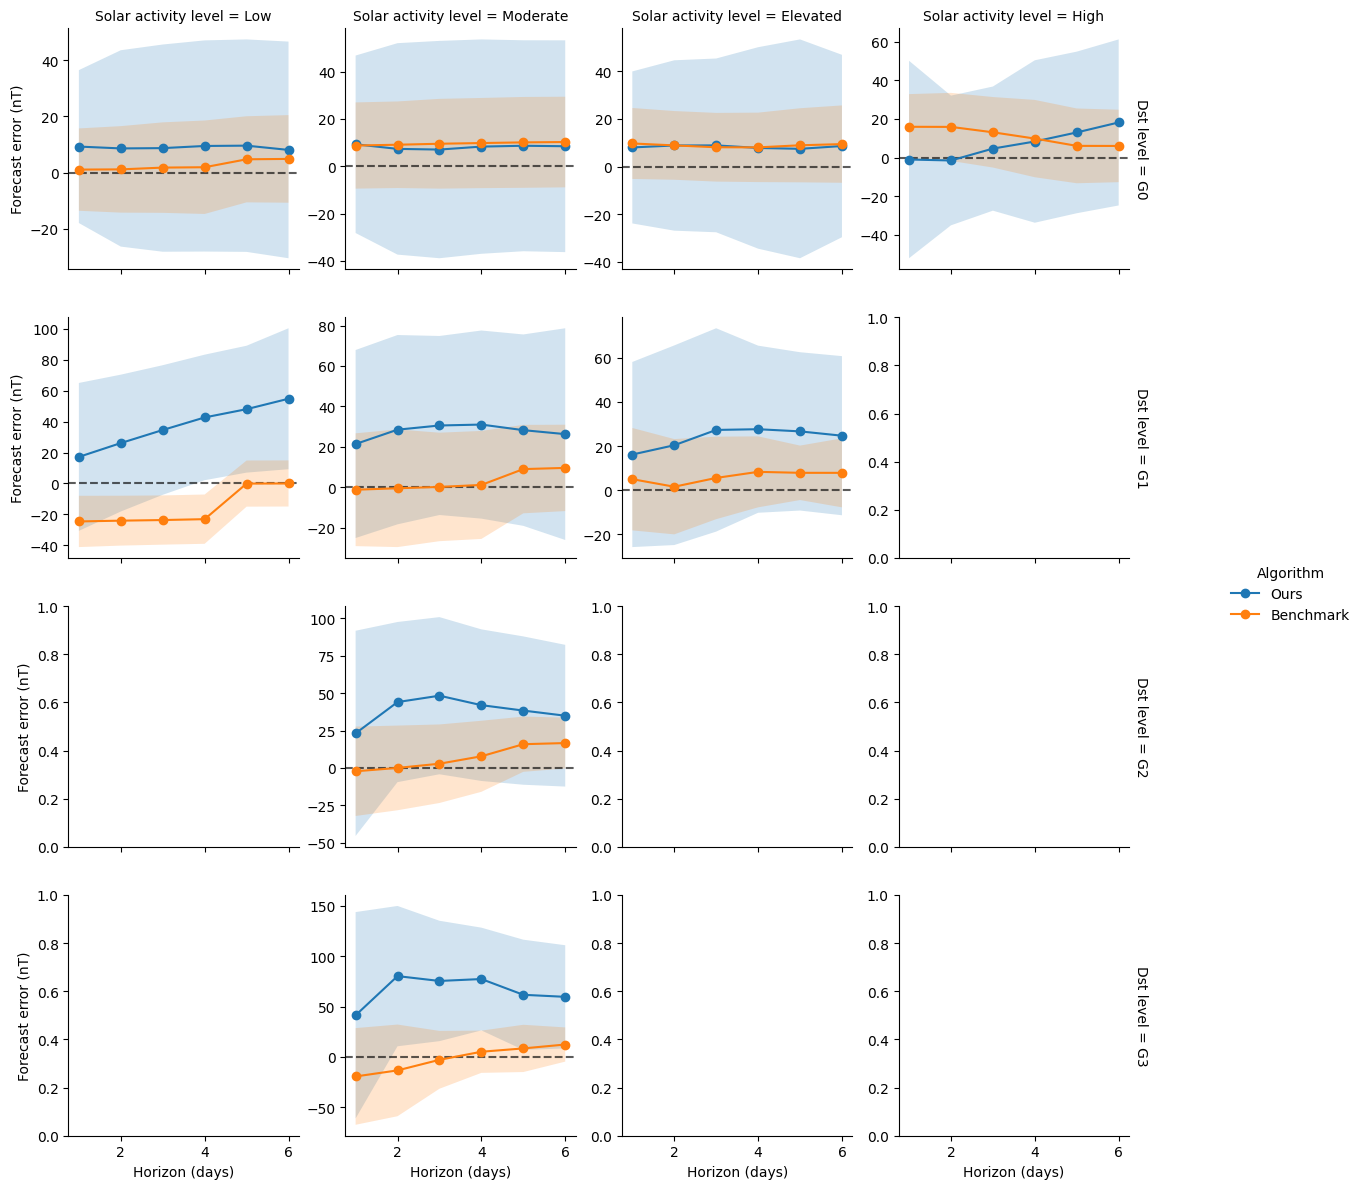

In [58]:
plot_results(data_dst, 'Dst level') 

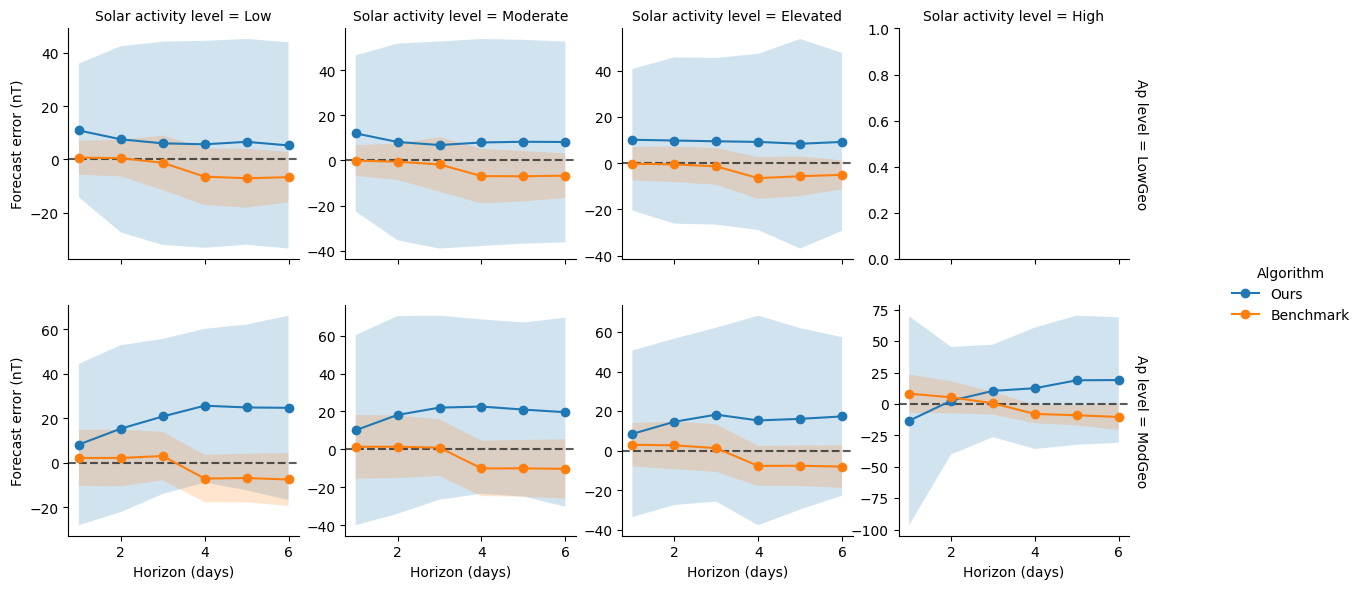

In [59]:
plot_results(data_ap, 'Ap level')